In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from linalg import *

In [ ]:
sndata = pd.read_csv('lcparam_full_long.txt', sep=' ', skiprows=0)
z = sndata['zcmb'].to_numpy()
mb = sndata['mb'].to_numpy()
dmb = sndata['dmb'].to_numpy()

In [28]:
dmb_matrix = np.diag(dmb**2)  # Covariance matrix assuming uncorrelated errors

In [29]:
dmb_matrix

array([[0.0158886 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01384152, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04227136, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.05248681, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03948169,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0697224 ]], shape=(1048, 1048))

In [37]:
cov_flatten = np.loadtxt('sys_full_long.txt', delimiter=' ')
cov_T = []
for i in range(1048):
    cov_row = cov_flatten[i*1048:(i+1)*1048]
    cov_T.append(cov_row)
print(any(cov_T[i][i] == 0 for i in range(1048)))  # Check for zero diagonal elements
cov = np.array(cov_T) + dmb_matrix

False


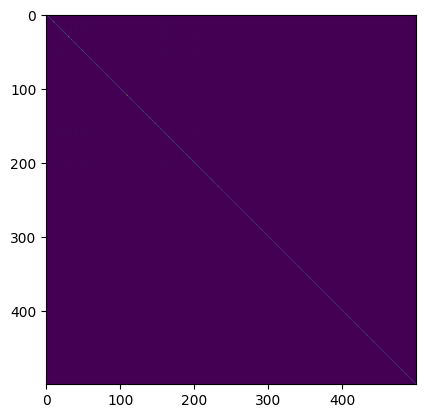

In [33]:
plt.imshow(cov[:500,:500], cmap='viridis')

In [ ]:
from scipy.integrate import quad
from scipy.interpolate import interp1d


inv_cov = inv_matrix(cov)
class Regression:
    def __init__(self, **kwargs):
        data = kwargs['data'] if 'data' in kwargs else None
        cov = data['cov'] if 'cov' in data else None
        if data is None or cov is None:
            raise ValueError("Data must be provided for regression.")
        self.z = data['z']
        self.mb = data['mb']
        self.inv_cov = inv_matrix(cov)
        self.zinterp = np.linspace(min(self.z), max(self.z), 300)
    def h0_th(self, Om0):
        return np.sqrt(1-Om0 + Om0*(1+self.z)**3)
    def DL_th(self, Om0):
        z = self.zinterp
        intgral = interp1d(z, [quad(0, zi, Om0) for zi in z], kind='cubic', fill_value="extrapolate")
        dl = 5*np.log10(1+z) + 5*np.log10(np.array([self.integrate(0, zi, Om0) for zi in z]))

def vec(a):
    return np.array([3, 2, 4]) + np.ones(3)*a
def predict_alpha(arr, vec):
    one_vec = np.ones(len(arr))
    def derivative_chisq(a):
        return one_vec @ arr @ vec(a).T + vec(a) @ arr @ one_vec.T
    a_range = np.linspace(-1,1+0.1,20)
    vec(a)
def chisq(**kwargs):
    mb_th = kwargs['th'](kwargs['z'], **kwargs['Om0'])
    mb_data = kwargs['mb']



/Users/john1256/KASI_Ms/2025/Statistics_1/Assignment6/linalg.py:31: RuntimeWarning: invalid value encountered in scalar divide
  L[j][i] = (arr[j][i] - np.sum(L[j,:i] * U[:i,i])) / U[i][i]
/Users/john1256/KASI_Ms/2025/Statistics_1/Assignment6/linalg.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  L[j][i] = (arr[j][i] - np.sum(L[j,:i] * U[:i,i])) / U[i][i]
/Users/john1256/KASI_Ms/2025/Statistics_1/Assignment6/linalg.py:31: RuntimeWarning: invalid value encountered in multiply
  L[j][i] = (arr[j][i] - np.sum(L[j,:i] * U[:i,i])) / U[i][i]
/Users/john1256/KASI_Ms/2025/Statistics_1/Assignment6/linalg.py:26: RuntimeWarning: invalid value encountered in multiply
  U[i][j] = arr[i][j] - np.sum(L[i,:i] * U[:i,j])
/Users/john1256/KASI_Ms/2025/Statistics_1/Assignment6/linalg.py:42: RuntimeWarning: invalid value encountered in multiply
  inv_L[i][j] = -np.sum(L[i,j:i] * inv_L[j:i,j]) / L[i][i]


KeyboardInterrupt: 